In [325]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import tensorflow as tf
import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis as cfv
from scipy.interpolate import LinearNDInterpolator
import sys
import os

In [355]:
A = A(np.array([0,0]))

In [412]:
nodes_els = nodes[elements]

A11 = np.array([[1,0],[0,1]])
A12 = np.array([[0,0],[0,0]])
A22 = np.array([[1,0.5],[0.5,1]])
A = np.concatenate([
    np.concatenate([A11,A12],axis=1),
    np.concatenate([A12,A22],axis=1)
],axis=0)

r = int(A.shape[-1]/2)
a = None
# a = np.roll(nodes_els[:,:,0],1,axis=1)*np.roll(nodes_els[:,:,1],2,axis=1) - np.roll(nodes_els[:,:,0],2,axis=1)*np.roll(nodes_els[:,:,1],1,axis=1)
b = (np.roll(nodes_els[:,:,1],1,axis=1) - np.roll(nodes_els[:,:,1],2,axis=1)).reshape(-1,3,1)
c = (np.roll(nodes_els[:,:,0],2,axis=1) - np.roll(nodes_els[:,:,0],1,axis=1)).reshape(-1,3,1)
Area = np.abs(np.matmul(nodes_els[:,:,0].reshape(-1,1,3),b))/2
B = np.concatenate([
    np.concatenate([b[:,i:i+1]*np.eye(r).reshape(1,r,r) for i in range(3)],-1),
    np.concatenate([c[:,i:i+1]*np.eye(r).reshape(1,r,r) for i in range(3)],-1)
],-2)/(2*Area)
B_T = np.transpose(B,(0,2,1))
K_els = np.matmul(np.matmul(B_T,A),B)*Area

In [413]:
def PlotMesh(nodes, boundaryNodes, elements):
    plt.figure(figsize=(10,10))
    plt.scatter(nodes[:,0],nodes[:,1])
    if elements.shape[1] == 4:
        for el in elements:
            plt.plot(nodes[[el[0],el[1],el[3],el[2],el[0]],0], nodes[[el[0],el[1],el[3],el[2],el[0]],1], 'k')
    elif elements.shape[1] == 3:
        for el in elements:
            plt.plot(nodes[[el[0],el[1],el[2],el[0]],0], nodes[[el[0],el[1],el[2],el[0]],1], 'k')
    plt.plot(nodes[boundaryNodes,0],nodes[boundaryNodes,1],'r')
    plt.gca().set_aspect('equal', adjustable='box')
    # plt.show()

def GetK_el_triang(A,nodes):
    r = int(A.shape[0]/2)
    # a = np.roll(nodes[:,0],1)*np.roll(nodes[:,1],2) - np.roll(nodes[:,0],2)*np.roll(nodes[:,1],1)
    b = np.roll(nodes[:,1],1) - np.roll(nodes[:,1],2)
    c = np.roll(nodes[:,0],2) - np.roll(nodes[:,0],1)
    Area = np.abs(np.dot(nodes[:,0],b))/2
    B = np.concatenate([
        np.concatenate([b[i]*np.eye(r) for i in range(3)],1),
        np.concatenate([c[i]*np.eye(r) for i in range(3)],1)
    ],0)/(2*Area)
    return np.dot(np.dot(B.T,A),B)*Area


def GetK(nodes_els, A):
    r = int(A.shape[0]/2)
    b = (np.roll(nodes_els[:,:,1],1,axis=1) - np.roll(nodes_els[:,:,1],2,axis=1)).reshape(-1,3,1)
    c = (np.roll(nodes_els[:,:,0],2,axis=1) - np.roll(nodes_els[:,:,0],1,axis=1)).reshape(-1,3,1)
    Area = np.abs(np.matmul(nodes_els[:,:,0].reshape(-1,1,3),b))/2
    B = np.concatenate([
        np.concatenate([b[:,i:i+1]*np.eye(r).reshape(1,r,r) for i in range(3)],-1),
        np.concatenate([c[:,i:i+1]*np.eye(r).reshape(1,r,r) for i in range(3)],-1)
    ],-2)/(2*Area)
    B_T = np.transpose(B,(0,2,1))
    return np.matmul(np.matmul(B_T,A),B)*Area

def SolveFEM(nodes, elements, boundaryNodes, BCfunc, alpha, internalNodes, r, A, A_nl=False, l=None):
    if l is None:
        l = np.zeros((nodes.shape[0], r))
    if not A_nl:
        A_l = A

    # Assemble the global stiffness matrix
    K = np.zeros((nodes.shape[0]*r, nodes.shape[0]*r))
    for el in elements:
        el_idx = [[r*k+j for j in range(r)] for k in el]
        el_idx = np.concatenate(el_idx)
        nodes_el = tf.gather(nodes, indices=el)
        X_idx,Y_idx = np.meshgrid(el_idx,el_idx)
        if A_nl:
            A_l = A(l[el_idx])
        # print(A_l)
        K_el = GetK_el_triang(A_l,nodes_el)
        K[Y_idx,X_idx] += K_el

    # Apply Dirichlet BC
    l_BC = BCfunc(alpha*2*np.pi)
    bc_idx = [[r*i+j for j in range(r)] for i in boundaryNodes]
    bc_idx = np.concatenate(bc_idx)
    internal_idx = [[r*i+j for j in range(r)] for i in internalNodes]
    internal_idx = np.concatenate(internal_idx)

    f = - (K[:,bc_idx] @ l_BC.flatten().reshape(-1,1))

    K_BC = K[internal_idx,:][:,internal_idx]
    f = f[internal_idx]

    # Solve the system
    l_internal = np.linalg.solve(K_BC, f)
    n_CDOF = int(l_internal.shape[0]/r)
    l_internal = l_internal.reshape(n_CDOF, r)

    l[internalNodes,:] = l_internal
    l[boundaryNodes,:] = l_BC.reshape(-1,r)
    return l

def SolveFEM_itt(nodes, elements, boundaryNodes, BCfunc, alpha, internalNodes, r, A, tol=1e-8,show_err=False, max_iter=10):

    l_prev = SolveFEM(nodes, elements, boundaryNodes, BCfunc, alpha, internalNodes, r, A, A_nl=True, l=None)

    err = 1
    i = 1
    while err>tol and i<max_iter:
        l = SolveFEM(nodes, elements, boundaryNodes, BCfunc, alpha, internalNodes, r, A, A_nl=True, l=l_prev.copy())
        err = ((l-l_prev)**2).mean()
        if show_err:
            print(f'Iteration {i}; err = {err}')
        i+=1
        l_prev = l.copy()

    return l, i

def PlotFEMsolution(nodes, elements,l):
    if elements.shape[1] == 4:
        # Convert quadrlateral mesh to triangular mesh
        elements = np.concatenate([elements[:,:3],elements[:,1:]],0)

    # Create a Triangulation object
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

    # Plotting
    r = l.shape[1]
    plt.figure(figsize=(6*r,5))
    for i in range(r):
        plt.subplot(1,r,i+1)
        plt.tricontourf(triangulation, l[:,i],10)
        plt.colorbar()
        # plt.scatter(nodes[:,0],nodes[:,1],s=1,c='k')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.gca().set_aspect('equal', adjustable='box')
    return 

In [414]:
def GenerateGeometry(p):
    g = cfg.Geometry()
    for i in range(p.shape[0]):
        g.point(list(p[i]))
    g.spline(list(range(p.shape[0]))+[0])
    g.surface([0])
    return g

def MeshSurface(g,elSize):
    mesh = cfm.GmshMesh(g)
    mesh.elType = 2       # Degrees of freedom per node.
    mesh.dofsPerNode = 1     # Factor that changes element sizes.
    mesh.elSizeFactor = elSize # Element size Factor
    nodes, edof, dofs, bdofs, elementmarkers = mesh.create()

    elements = edof-1
    boundaryNodes = np.array(bdofs[0])-1
    internalNodes = np.setdiff1d(np.arange(nodes.shape[0]), boundaryNodes)

    alpha = GetDistAlongBoundary(nodes,boundaryNodes)
    return nodes, elements, boundaryNodes, internalNodes, alpha

def GetRandomBCfuncAlpha(n_order=3, r=1):
    p = np.random.randn(2,n_order,r)
    BCfunc_unscaled = lambda alpha: np.array([[p[0,j,i]*np.cos((j+1)*alpha) + p[1,j,i]*np.sin((j+1)*alpha) for i in range(r)] for j in range(n_order)]).T.sum(axis=-1)
    alpha = np.linspace(0,2*np.pi,100)
    vals = BCfunc_unscaled(alpha)
    vals_max = np.max(vals)
    vals_min = np.min(vals)
    BCfunc = lambda alpha: (BCfunc_unscaled(alpha)-vals_min)/(vals_max-vals_min)*2-1
    return BCfunc

def SortBoundaryNodes(boundaryNodes,nodes):
    boundaryNodesSorted = [boundaryNodes[0]]
    boundaryNodesNotSorted = np.delete(boundaryNodes,0)
    for i in range(1,len(boundaryNodes)):
        idx = ((nodes[boundaryNodes[i]]-nodes[boundaryNodesNotSorted])**2).sum(axis=1).argmin()
        boundaryNodesSorted.append(boundaryNodesNotSorted[idx])
        boundaryNodesNotSorted = np.delete(boundaryNodesNotSorted,idx)
    return np.array(boundaryNodesSorted)

def GetDistAlongBoundary(nodes,boundaryNodes):
    ds = [0]+[np.sqrt(((nodes[boundaryNodes[i-1]]-nodes[boundaryNodes[i]])**2).sum()) for i in range(boundaryNodes.shape[0])]
    s = np.cumsum(ds)
    s = s[:-1]/s[-1]
    return s

def GetRandomFixedPoints(n_min = 4,n_max = 10):
    n_points = np.random.randint(n_min,n_max)
    i = 0
    while True:
        angles = np.random.lognormal(0,1,n_points)
        angles = angles/np.sum(angles)*2*np.pi
        i += 1
        if np.all(angles<np.pi) and np.all(angles>np.pi/6):
            break
    # print(i)
    angles = np.cumsum(angles)-angles[0]
    # r = np.abs(np.random.randn(n_points)+1)+0.5
    # r[r>3] = 3
    r = np.random.uniform(0.5,1.5,n_points)
    points = np.zeros((n_points,2))
    for i in range(angles.shape[0]):
        points[i,:] = r[i]*np.array([np.cos(angles[i]),np.sin(angles[i])])
    return points

def GenerateRandomSolution(n_min = 4, n_max = 10, elSize = 0.07, n_order = 3):
    points = GetRandomFixedPoints(n_min,n_max)
    g = GenerateGeometry(points)
    nodes, elements, boundaryNodes, internalNodes, alpha = MeshSurface(g,elSize)
    boundaryNodes = SortBoundaryNodes(boundaryNodes,nodes)
    A = lambda u: np.concatenate([
    np.concatenate([[[10*np.max([u.mean(),0])**2+0.5]],[[0]]],axis=1),
    np.concatenate([[[0]],[[10*np.max([u.mean(),0])**2+0.5]]],axis=1)
    ],axis=0)
    r = 1
    BCfunc = GetRandomBCfuncAlpha(n_order,r=r)
    l,_ = SolveFEM_itt(nodes, elements, boundaryNodes, BCfunc, alpha, internalNodes, r, A, tol=1e-8,show_err=True, max_iter=20)
    mesh = {'nodes':nodes,'elements':elements,'boundaryNodes':boundaryNodes,'internalNodes':internalNodes,'points':points, 'alpha':alpha}
    return l, mesh
    

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpxtim14ir/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpxtim14ir/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00852083s, CPU 0.008092s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0151691s, CPU 0.014315s)
Info    : 743 nodes 1481 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpxtim14ir/meshFile.msh'...
Info    : Done writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpxtim14ir/meshFile.msh'


Iteration 1; err = 0.026470403319180432
Iteration 2; err = 0.008254466680863888
Iteration 3; err = 0.002201103737627005
Iteration 4; err = 0.00040960129990542715
Iteration 5; err = 6.830669865731506e-05
Iteration 6; err = 2.2702249196622678e-05
Iteration 7; err = 3.7491109136093207e-06
Iteration 8; err = 1.31094968204913e-06
Iteration 9; err = 2.02334167926512e-07
Iteration 10; err = 6.87186423524676e-08
Iteration 11; err = 1.1621525618536569e-08
Iteration 12; err = 3.478623387305613e-09


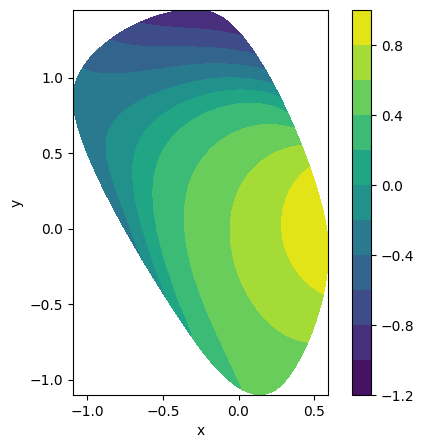

In [416]:
np.random.seed(1)
l, mesh =  GenerateRandomSolution(n_min = 4, n_max = 8, elSize = 0.07, n_order = 3)

triangulation = PlotFEMsolution(mesh['nodes'], mesh['elements'],l)
# plt.scatter(nodes[:,0],nodes[:,1],c='k',s=1)
nodes = mesh['nodes']
boundaryNodes = mesh['boundaryNodes']
points = mesh['points']
elements = mesh['elements']

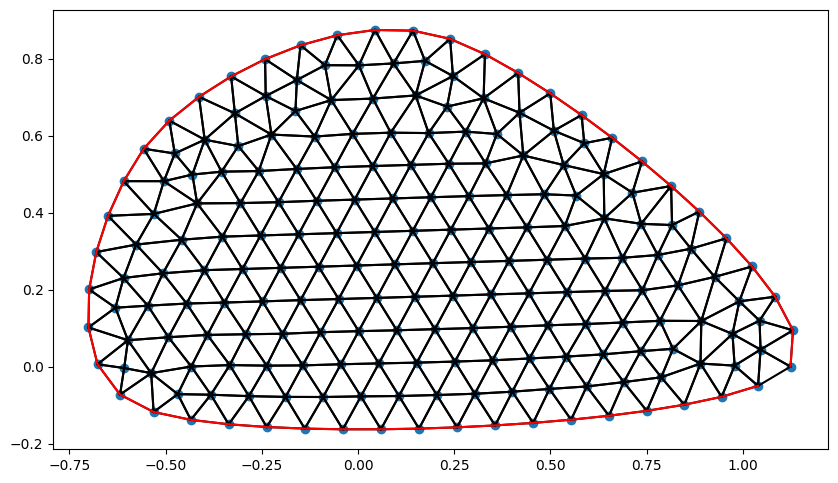

In [349]:
PlotMesh(mesh['nodes'], mesh['boundaryNodes'], mesh['elements'])

Iteration 1; err = 0.02700666163094086
Iteration 2; err = 0.011040715339435021
Iteration 3; err = 0.0031492805199655424
Iteration 4; err = 0.0006046213746053647
Iteration 5; err = 7.824732166036742e-05
Iteration 6; err = 2.6529835217363227e-05
Iteration 7; err = 4.577933074487054e-06
Iteration 8; err = 1.1751486244661872e-06
Iteration 9; err = 2.9111508264641873e-07
Iteration 10; err = 4.364217155540716e-08
Iteration 11; err = 1.6227922444304482e-08
Iteration 12; err = 2.040980627512531e-09


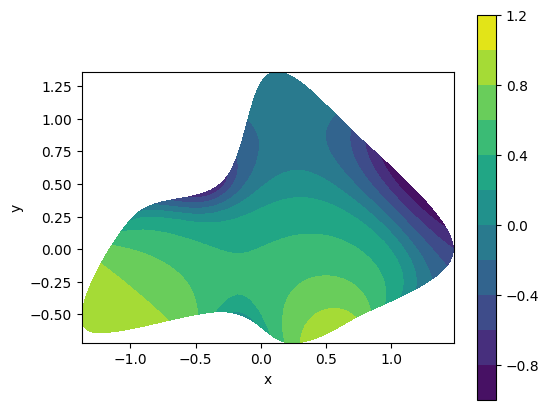

In [238]:
# A11 = np.array([[1,0],[0,1]])
# A12 = np.array([[0,0],[0,0]])
# A22 = np.array([[1,0.5],[0.5,1]])
# A = np.concatenate([
#     np.concatenate([A11,A12],axis=1),
#     np.concatenate([A12,A22],axis=1)
# ],axis=0)
# r=2


A = lambda u: np.concatenate([
    np.concatenate([[[10*np.max([u.mean(),0])**2+0.5]],[[0]]],axis=1),
    np.concatenate([[[0]],[[10*np.max([u.mean(),0])**2+0.5]]],axis=1)
],axis=0)
A_lin = A(np.array([0]))
r = 1

# Define Dirichlet BC
# n_order = 3
# p = np.random.randn(2,n_order,r)
# BCfunc_unscaled = lambda alpha: np.array([[p[0,j,i]*np.cos((j+1)*alpha) + p[1,j,i]*np.sin((j+1)*alpha) for i in range(r)] for j in range(n_order)]).T.sum(axis=-1)
# alpha = np.linspace(0,2*np.pi,100)
# vals = BCfunc_unscaled(alpha)
# vals_max = np.max(vals)
# vals_min = np.min(vals)
# BCfunc = lambda alpha: (BCfunc_unscaled(alpha)-vals_min)/(vals_max-vals_min)*2-1

internalNodes = np.setdiff1d(np.arange(nodes.shape[0]), boundaryNodes)
l_lin = SolveFEM(nodes, elements, boundaryNodes, BCfunc, internalNodes, r, A_lin, A_nl=False, l=None)
l,iters = SolveFEM_itt(nodes, elements, boundaryNodes, BCfunc, internalNodes, r, A, tol=1e-8,show_err=True, max_iter=20)
triangulation = PlotFEMsolution(nodes, elements,l)

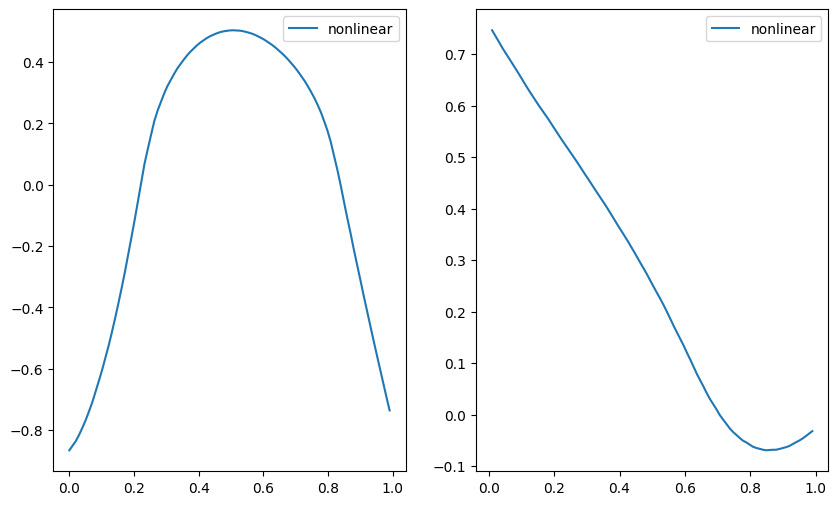

In [347]:
interp = LinearNDInterpolator(nodes, l)
# interp_lin = LinearNDInterpolator(nodes, l_lin)
scaler = np.linspace(0,1,100).reshape(-1,1)
n = points.shape[0]//2
n_2 = points.shape[0]//4
points_line1 = (points[0:1,:]*(1-scaler)+points[n:n+1,:]*scaler)
points_line2 = (points[n_2:n_2+1,:]*(1-scaler)+points[n_2+n:n_2+n+1,:]*scaler)
z1 = interp(points_line1)
# z1_lin = interp_lin(points_line1)
z2 = interp(points_line2)
# z2_lin = interp_lin(points_line2)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(scaler,z1[:,:],label='nonlinear')
# plt.plot(scaler,z1_lin[:,:],label='linear')
plt.legend()
plt.subplot(1,2,2)
plt.plot(scaler,z2[:,:],label='nonlinear')
# plt.plot(scaler,z2_lin[:,:],label='linear')
plt.legend()

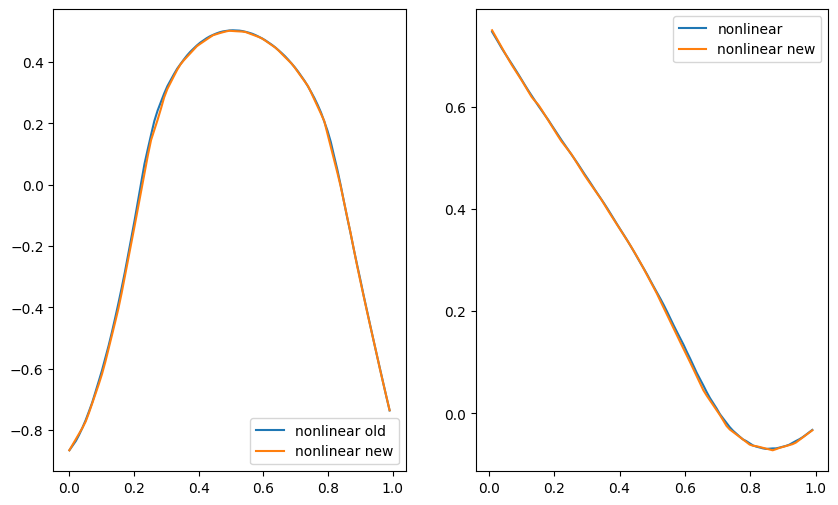

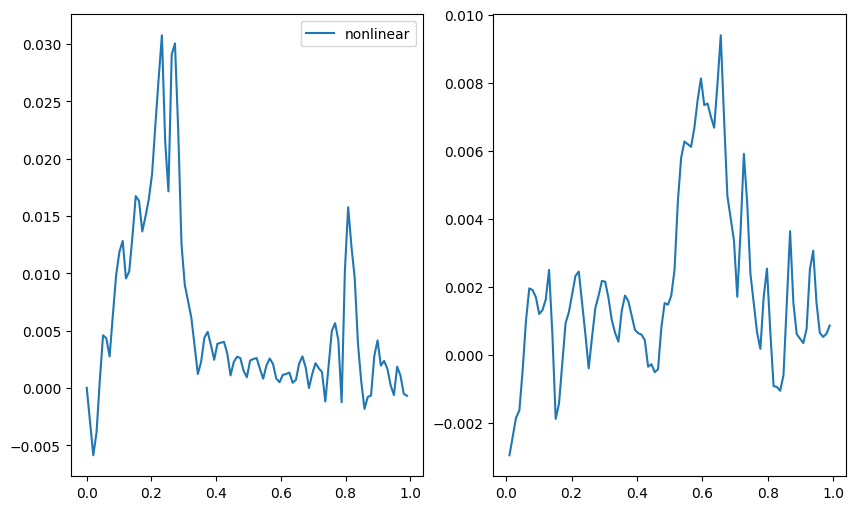

In [350]:
interp = LinearNDInterpolator(nodes, l)
# interp_lin = LinearNDInterpolator(nodes, l_lin)
z1_new = interp(points_line1)
# z1_lin_new = interp_lin(points_line1)
z2_new = interp(points_line2)
# z2_lin_new = interp_lin(points_line2)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(scaler,z1[:,:],label='nonlinear old')
# plt.plot(scaler,z1_lin[:,:],label='linear old')
plt.plot(scaler,z1_new[:,:],label='nonlinear new')
# plt.plot(scaler,z1_lin_new[:,:],label='linear new')
plt.legend()
plt.subplot(1,2,2)
plt.plot(scaler,z2[:,:],label='nonlinear')
# plt.plot(scaler,z2_lin[:,:],label='linear')
plt.plot(scaler,z2_new[:,:],label='nonlinear new')
# plt.plot(scaler,z2_lin_new[:,:],label='linear new')
plt.legend()

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(scaler,z1[:,:]-z1_new[:,:],label='nonlinear')
# plt.plot(scaler,z1_lin[:,:]-z1_lin_new[:,:],label='linear')
plt.legend()
plt.subplot(1,2,2)
plt.plot(scaler,z2[:,:]-z2_new[:,:],label='nonlinear')
# plt.plot(scaler,z2_lin[:,:]-z2_lin_new[:,:],label='linear')